# Finding a Steady State with Newton-Raphson
*Tom Bertalan, July 2021*

A basic task with dynamical systems research is to find the (or a) steady state $u^*$ of a dynamical system

$$\frac{\mathrm{d}u}{\mathrm{d}t} = f(u).$$

This amounts to finding root(s) of $f$.

A classic rootfinding technique is Newton's method, which, for 1-dimensional/scalar $x$ can be summarized by the recurrence

$$u_{k+1} = x_k - \frac{f(u_k)}{f'(u_k)},$$

where $f'(u) \equiv \frac{\mathrm{d}f(u)}{\mathrm{d}u}$ is the Jacobian of $f$. In higher dimension the quotient from the "division" by $f'$ becomes the solution of a square system of linear equations.

In [1]:
import numpy as np, matplotlib.pyplot as plt

We'll demonstrate this procedure for the [Brusselator](https://en.wikipedia.org/wiki/Brusselator) (with $u=[x, y]$).

In [2]:
A_param = 1.0
B_param = 3.0

In [3]:
def f(xy):
    x = xy[..., 0]
    y = xy[..., 1]
    term1 = x**2*y
    term2 = B_param*x
    dxdt = A_param + term1 - term2 - x
    dydt = term2 - term1
    return np.stack([dxdt, dydt], axis=-1).reshape(xy.shape)

There is a steady state at $x* = A$, $y^* = B / A$.

In [4]:
known_ss = np.array([A_param, B_param / A_param])
known_ss, f(known_ss)

(array([1., 3.]), array([0., 0.]))

For the Brusselator, we can define the Jacobian analytically. 

In [5]:
def fprime(xy):
    x = xy[..., 0]
    y = xy[..., 1]
    term1_x = 2*x*y
    term1_y = x**2
    term2_x = B_param
    term2_y = 0
    dxdotdx = term1_x - term2_x - 1.0
    dxdotdy = term1_y - term2_y
    dydotdx = B_param - term1_x
    dydotdy = -term1_y
    return np.array([
        [dxdotdx, dxdotdy],
        [dydotdx, dydotdy],
    ])

In [6]:
fprime(known_ss)

array([[ 2.,  1.],
       [-3., -1.]])

Verify.

In [7]:
xs, ys = known_ss
a = A_param
b = B_param

np.array([
    [2*xs*ys - b - 1, xs**2],
    [b - 2*xs*ys, -xs**2],
])

array([[ 2.,  1.],
       [-3., -1.]])

Define the netwon iteration.

In [8]:
def newton_step(xn, fn, fpn):
    return xn - np.linalg.solve(fpn, fn)

In [9]:
np.set_printoptions(formatter={
    'float': lambda x: "{0:0.4f}".format(x)
})
def Newton(initial, f=f, fp=fprime, n_iter=10, verbosity=2, do_plot=True, known_ss=None):
    initial = np.asarray(initial)
    xn = initial
    result = dict(history=dict(x=[], f=[], fp=[], dx=[], jacCond=[]))
    hist = result['history']
    for i in range(n_iter):
        fn = f(xn) 
        fpn = fp(xn)
        xnext = newton_step(xn, fn, fpn)
        hist['x'].append(np.copy(xn))
        hist['f'].append(np.copy(fn))
        hist['fp'].append(np.copy(fpn))
        hist['dx'].append(np.copy(xnext - xn))
        hist['jacCond'].append(np.linalg.cond(fpn))
        if verbosity:
            fnorm = np.linalg.norm(fn)
            condJ = np.linalg.cond(fpn)
            xstr = (f'x={xn} ' if verbosity > 1 else '').ljust(15)
            print(f'{i}: {xstr} ||f||={fnorm:.3e} cond(J)={condJ:.3e}')
        xn = xnext
    result['x'] = xn
    
    for key in result['history'].keys():
        result['history'][key] = np.array(result['history'][key])
    
    if do_plot:
        iters = np.array(range(len(result['history']['f'])))
        half_iters = 0.5 + iters
            
        fig, ax = plt.subplots()
        fnorms = np.linalg.norm(hist['f'], axis=1)
        ax.plot(iters, fnorms, label='RHS norm $|f|$', marker='s')
        print(hist['dx'].shape)
        ax.plot(iters, np.linalg.norm(hist['dx'], axis=1),
                marker='*', label=r'Newton step size $|\Delta x|$', alpha=.9, linewidth=4, linestyle='--')
        
        ax.plot(iters, hist['jacCond'], label=r'Condition number of $df/dx$', linestyle='-.')
        
        if known_ss is not None:
            err_from_known = np.linalg.norm(known_ss - hist['x'], axis=1)
            ax.plot(iters, err_from_known, label='Err $||x - x^*||$ vs known SS $x^*$', linestyle=':', marker='d')
            
        
        tax = ax.twinx()
        nonzero = fnorms != 0
        include = nonzero[:-1]
        col = 'magenta'
        tax.plot(half_iters[:-1][include], np.diff(np.log10(fnorms))[include], color=col, linewidth=4, alpha=.6, marker='o')
        tax.set_ylabel('$f$ Slope (log scale) per Iterate', color=col)
        
        ax.set_yscale('log')
        ax.set_xlabel('Iterate Number')
        ax.legend(fontsize=10)
        ax.grid(True)
            
        print(np.linalg.norm(result['history']['f']))
    return result

0: x=[0.1000 0.1000]  ||f||=6.713e-01 cond(J)=2.472e+03
1: x=[1.0000 298.2000]  ||f||=4.175e+02 cond(J)=7.031e+05
2: x=[1.0000 3.0000]  ||f||=2.105e-11 cond(J)=1.493e+01
3: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
4: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
5: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
6: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
7: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
8: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
9: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
(10, 2)
417.47638328652755


/home/tsbertalan/.virtualenvs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tsbertalan/.virtualenvs/tfcpu/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


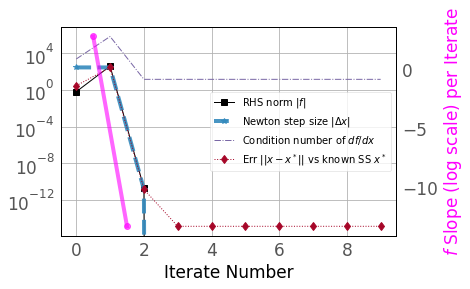

In [10]:
Newton([0.1, 0.1], known_ss=known_ss);

Try running Newton from a more outlandish initial guess.

0: x=[ 1000 -1000]  ||f||=1.414e+09 cond(J)=1.000e+07
1: x=[1.0000 -1998.0000]  ||f||=2.830e+03 cond(J)=3.199e+07
2: x=[1.0000 3.0002]  ||f||=3.221e-04 cond(J)=1.494e+01
3: x=[1.0000 3.0000]  ||f||=4.441e-16 cond(J)=1.493e+01
4: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
5: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
6: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
7: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
8: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
9: x=[1.0000 3.0000]  ||f||=0.000e+00 cond(J)=1.493e+01
(10, 2)
1414218511.4164643


/home/tsbertalan/.virtualenvs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10


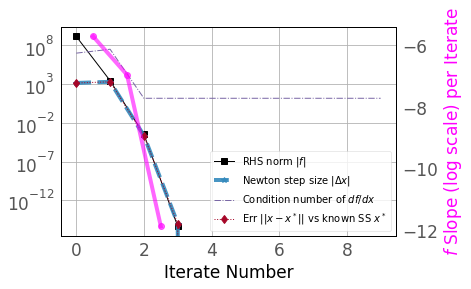

In [11]:
Newton([1000, -1000], known_ss=known_ss);

It still converges pretty quickly.